In [1]:
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout
from keras.models import Model, Sequential
from osgeo import osr, ogr, gdal
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np 

import keras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Параметры
path_train = "files 3/train_3.png" 
path_target = "files 3/target_3.png" 

size = 32

In [3]:
def split_image(path, size):
    img = Image.open(path).convert('L') 
    x, y = img.size  # ширина (x) и высота (y) изображения

    x = x // size
    y = y // size

    all = False 

    for i in tqdm(range(x)):
        for j in range(y): 
            mini_image = img.crop(box=(size * i, size * j, size * (i + 1), size * ( j + 1)))
            # mini_image.save('image{}{}.png'.format(str(i + 1), str(j + 1)))

            mini_image = np.array(mini_image.getdata())
            mini_image = np.reshape(mini_image, (1, size, size, 1)) 

            if i == 0 and j == 0:# переделать покрасивее потом
                all =  mini_image
            else:
                all = np.append(all, mini_image, axis=0) 
    print(np.shape(all)) 
    return all, [x, y]

In [4]:
target, target_size = split_image(path_target, size)

100%|██████████| 27/27 [00:00<00:00, 144.12it/s]

(378, 32, 32, 1)


In [5]:
train, train_size = split_image(path_train, size)

100%|██████████| 27/27 [00:00<00:00, 229.83it/s]

(378, 32, 32, 1)


In [89]:
train.max()

192

In [9]:
target.max()

1.0

In [6]:
target = target / 255.0 
# target = (target / 127.5) - 1 
train = train / train.max()
# train = train / (train.max() / 2) - 1 

In [7]:
target = np.reshape(target, (-1, size*size)) 

In [22]:
# model = Sequential([
#     Conv2D(64, (7,7), padding='same', activation=tf.nn.relu,
#                            input_shape=(size, size, 1)),
#     MaxPooling2D((2, 2), strides=2), 
#     Flatten(),
#     Dense(150, activation=tf.nn.relu),
#     Dense(size*size,  activation=tf.nn.softmax)
# ])


In [67]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 32)        7232      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 64)        204864    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 130)               5326

In [25]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


In [ ]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}


In [31]:
class ComputeSum(keras.layers.Layer):
    def __init__(self, input_dim):
        super(ComputeSum, self).__init__()
        self.total = tf.Variable(initial_value=tf.zeros((input_dim,)), trainable=False)

    def call(self, inputs):
        self.total.assign_add(tf.reduce_sum(inputs, axis=0))
        return self.total

In [24]:
Dense(32, activation='relu')


In [8]:
inp = Input(shape=(size, size, 1))
x = Conv2D(32, (15,15), padding='same', activation=tf.nn.relu) (inp)
x = MaxPooling2D((2, 2), strides=2)(x)
x = Conv2D(64, (9,9), padding='same', activation=tf.nn.relu)(x)
x = MaxPooling2D((2, 2), strides=2)(x)
x = Flatten()(x)
x = Dense(130, activation=tf.nn.relu)(x) 
x = Dropout(0.5)(x)
x = Dense(130, activation=tf.nn.relu)(x) 
x = Dropout(0.5)(x)

out = Dense(size*size,  activation=tf.nn.softmax)(x)
model = Model(inputs=inp, outputs=out)

In [32]:
model = Sequential([
    Conv2D(64, (15,15), padding='same', activation=tf.nn.relu,
                           input_shape=(size, size, 1)),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(128, (10,10), padding='same', activation=tf.nn.relu), 
    MaxPooling2D((2, 2), strides=2),
    Flatten(),
    Dense(130, activation=tf.nn.relu), 
#     Dense(130, activation=tf.nn.relu),
    Dense(size*size,  activation=tf.nn.softmax)
])


TypeError: __init__() missing 1 required positional argument: 'input_dim'

In [87]:
model = Sequential([
    Conv2D(128, (9,9), padding='same', activation=tf.nn.relu,
                           input_shape=(size, size, 1)),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(256, (9,9), padding='same', activation=tf.nn.relu), 
    MaxPooling2D((2, 2), strides=2),
    Flatten(),
    Dense(130, activation=tf.nn.relu),
    Dense(130, activation=tf.nn.relu),
    Dense(size*size,  activation=tf.nn.softmax)
])


In [88]:
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)


In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',       # categorical_crossentropy
              metrics=['accuracy'])

In [10]:
his = model.fit(train, target, epochs=300)

Epoch 1/300
12/12 [==============================] - 31s 19ms/step - loss: 0.0934 - accuracy: 0.0000e+00
Epoch 2/300
12/12 [==============================] - 0s 8ms/step - loss: 0.0958 - accuracy: 0.0000e+00
Epoch 3/300
12/12 [==============================] - 0s 7ms/step - loss: 0.1470 - accuracy: 0.0000e+00
Epoch 4/300
12/12 [==============================] - 0s 7ms/step - loss: 0.1153 - accuracy: 0.0000e+00
Epoch 5/300
12/12 [==============================] - 0s 7ms/step - loss: 0.1175 - accuracy: 0.0000e+00
Epoch 6/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0948 - accuracy: 0.0000e+00
Epoch 7/300
12/12 [==============================] - 0s 8ms/step - loss: 0.0806 - accuracy: 0.0000e+00
Epoch 8/300
12/12 [==============================] - 0s 7ms/step - loss: 0.1267 - accuracy: 0.0000e+00
Epoch 9/300
12/12 [==============================] - 0s 7ms/step - loss: 0.1010 - accuracy: 0.0000e+00
Epoch 10/300
12/12 [==============================] - 0s 7ms/step - los

12/12 [==============================] - 0s 7ms/step - loss: 0.0867 - accuracy: 0.0000e+00
Epoch 81/300
12/12 [==============================] - 0s 7ms/step - loss: 0.1270 - accuracy: 4.0700e-04
Epoch 82/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0913 - accuracy: 0.0047
Epoch 83/300
12/12 [==============================] - 0s 7ms/step - loss: 0.1149 - accuracy: 0.0041
Epoch 84/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0969 - accuracy: 0.0011
Epoch 85/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0956 - accuracy: 0.0014
Epoch 86/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0904 - accuracy: 0.0027
Epoch 87/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0976 - accuracy: 0.0024
Epoch 88/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0771 - accuracy: 0.0103
Epoch 89/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0864 - accuracy: 0.0022
Epoch

12/12 [==============================] - 0s 7ms/step - loss: 0.0759 - accuracy: 0.0022
Epoch 161/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0763 - accuracy: 0.0027
Epoch 162/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0635 - accuracy: 0.0027
Epoch 163/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0868 - accuracy: 8.6592e-04
Epoch 164/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0698 - accuracy: 0.0000e+00
Epoch 165/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0685 - accuracy: 0.0018
Epoch 166/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0934 - accuracy: 0.0109
Epoch 167/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0831 - accuracy: 0.0000e+00
Epoch 168/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0970 - accuracy: 8.1400e-04
Epoch 169/300
12/12 [==============================] - 0s 7ms/step - loss: 0.0889 - accur

KeyboardInterrupt: 

In [40]:
# his.history

In [12]:
test_index = 32

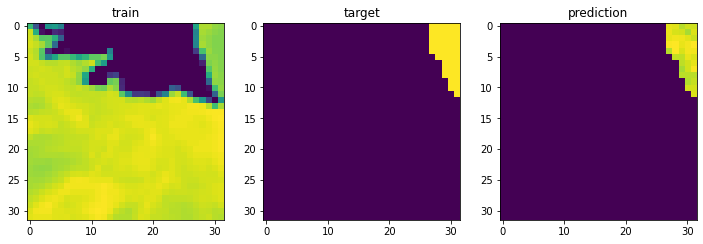

prediction max value =  0.024703778
prediction min value =  2.728938e-12
prediction mean value =  0.0009765624


In [26]:
b = np.reshape(train[test_index], (1, size, size, 1))
prediction = model.predict(b) 
prediction = np.reshape(prediction, (size, size)) 

train_img = np.reshape(train[test_index], (size, size)) 
target_img = np.reshape(target[test_index], (size, size)) 

fig, axes = plt.subplots(1, 3)

axes[0].imshow(train_img)
axes[0].set_title('train')

axes[1].imshow(target_img)
axes[1].set_title('target')

axes[2].imshow(prediction)
axes[2].set_title('prediction')

fig.set_figwidth(12)    #  ширина и
fig.set_figheight(6)    #  высота "Figure"
plt.show()
print("prediction max value = ", prediction.max())
print("prediction min value = ", prediction.min())
print("prediction mean value = ", prediction.mean())

In [96]:
 (prediction*1000).max()

4.0536766

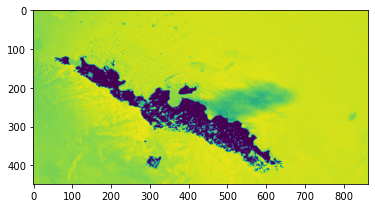

In [76]:
img = Image.new('L', (size*train_size[0], size*train_size[1]))

for i in tqdm(range(train_size[0])):
    for j in range(train_size[1]):

        train_img = np.reshape(train[i * train_size[1] + j], (size, size)) 
        a = train_img.astype('uint8') 
        img1 =  Image.fromarray(a)
        img.paste(img1, (i*size, j*size))
        
img.save("2.png")
plt.imshow(img) 

100%|██████████| 27/27 [00:15<00:00,  1.76it/s]


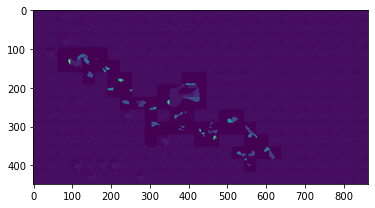

In [129]:
img = Image.new('L', (size*train_size[0], size*train_size[1]))

for i in tqdm(range(train_size[0])):
    for j in range(train_size[1]):

        b = np.reshape(train[i * train_size[1] + j], (1, size, size, 1))
        prediction = model.predict(b)
        prediction = prediction * 10000
        
        train_img = np.reshape(prediction, (size, size)) 
        a = train_img.astype('uint8') 
        img1 =  Image.fromarray(a)
        img.paste(img1, (i*size, j*size))
        

plt.imshow(img) 
# img.save("9.png")

In [26]:
print(prediction)

[[1.1317295e-09 5.2061274e-08 6.8524901e-07 ... 4.2793651e-08
  1.8844513e-07 7.1384704e-08]
 [1.1396277e-08 2.8596627e-08 3.2344158e-07 ... 2.6575032e-08
  4.8888474e-08 4.6598196e-09]
 [3.1485685e-09 2.5167264e-08 2.2362080e-08 ... 2.2740403e-07
  2.9930806e-07 1.2725336e-07]
 ...
 [2.8482857e-06 2.0997115e-06 1.7216238e-06 ... 1.2906146e-05
  7.5013650e-06 9.0720559e-06]
 [7.6661464e-03 7.4512274e-03 1.2095799e-06 ... 6.9532134e-06
  9.9646077e-06 9.5794658e-06]
 [7.6260320e-03 7.4983542e-03 7.5413492e-03 ... 7.0676970e-06
  5.2254068e-06 6.1871892e-06]]


In [17]:
i = 0
# поиск индекса картинки с маской = 1
while (target[i].max() < 1):
    i+=1
print(i)

31


In [130]:
model_name = "model_inp=32_e=30000"

In [131]:
path = f'models/1/{model_name}.h5'
model.save(path)  

In [63]:
path = f'models/1/{model_name}.h5'
model = tf.keras.models.load_model(path)